<a href="https://colab.research.google.com/github/Nikita-devel/DS_Hw_4/blob/main/Hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання та регуляризація




У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написаний коментар з інструкціями, потрібно написати код, що виконує ці інструкції. Решту клітинок із кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми працюватимемо з датасетом __"bikes_rent.csv"__, у якому по днях записано календарну інформацію та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати задачу регресії.

### Знайомство з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [3]:
df = pd.read_csv("https://drive.usercontent.google.com/download?id=1iabVEvH3jcxRWY6whRYMMV9fwGHMASLs&export=download&authuser=0")

Для кожного дня прокату відомі такі ознаки:
* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 - немає свята, 1 - є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речовинні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з дійсними, тому що на них задано порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами вам потрібно побудувати 12 графіків. На кожному має бути зображено залежність чергового атрибута від змінної **cnt**.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    int64  
 1   yr              731 non-null    int64  
 2   mnth            731 non-null    int64  
 3   holiday         731 non-null    int64  
 4   weekday         731 non-null    int64  
 5   workingday      731 non-null    int64  
 6   weathersit      731 non-null    int64  
 7   temp            731 non-null    float64
 8   atemp           731 non-null    float64
 9   hum             731 non-null    float64
 10  windspeed(mph)  731 non-null    float64
 11  windspeed(ms)   731 non-null    float64
 12  cnt             731 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 74.4 KB


In [6]:
df_features = df.columns[:-1]
df_target = df.columns[-1]
# print(f"{df_features=}")
# print(f"{df_target=}")

from matplotlib import pyplot as plt
import seaborn as sns

def plot_series(ax, df, xlabel, ylabel):
  xs = df[xlabel]
  ys =  df[ylabel]
  ax.set_title(f'{ylabel} from {xlabel}')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.bar(xs, ys)

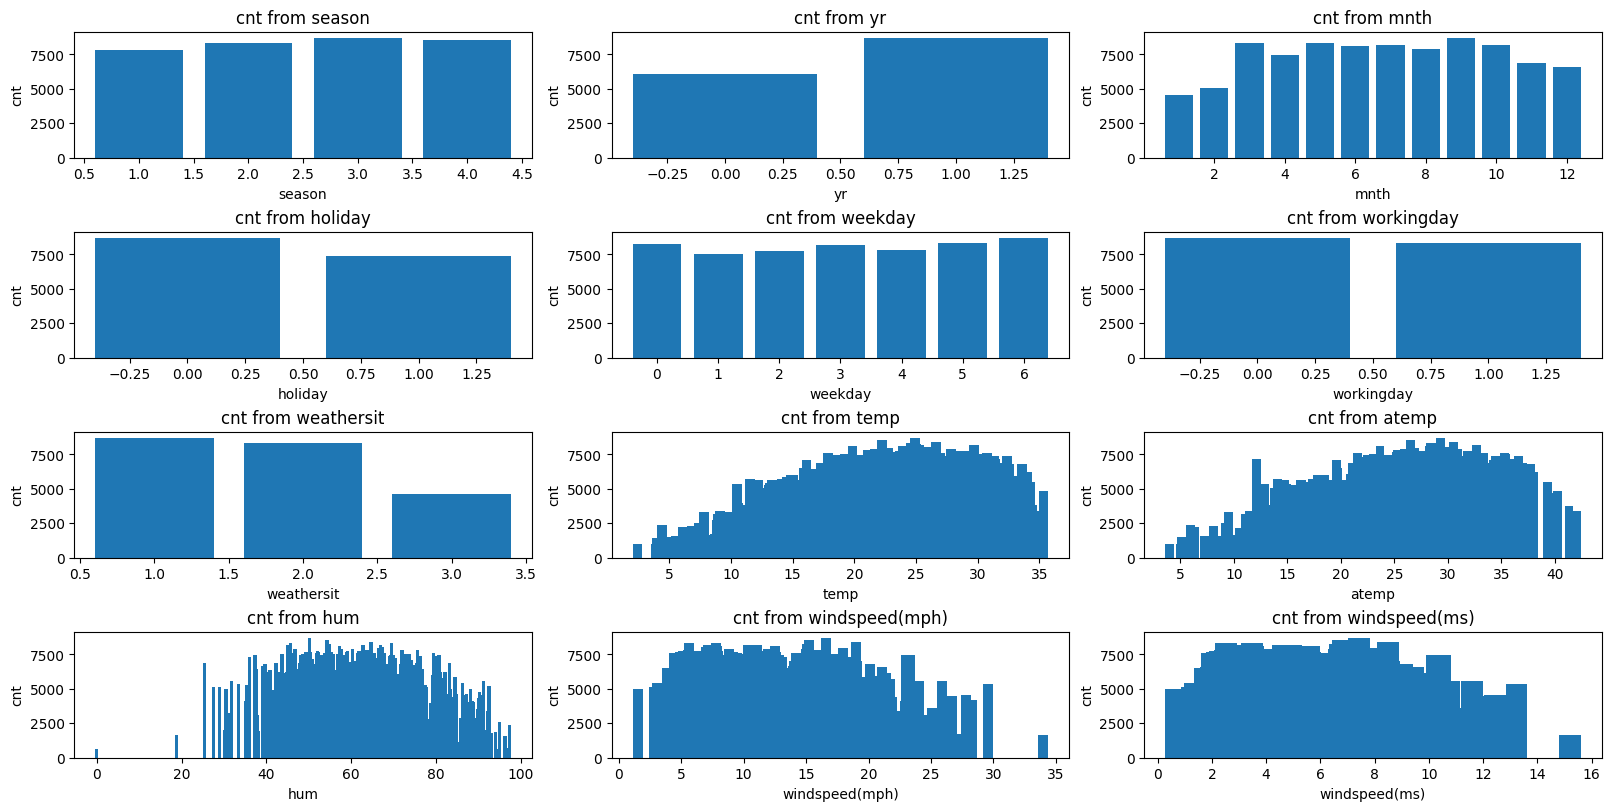

In [7]:
cols = 3
fig, axs = plt.subplots( len(df_features) // cols, cols, figsize=(16,8), layout='constrained')

for ax, feature in zip(axs.flat, df_features):
 plot_series(ax, df, feature, df_target  )

__Питання:__
1. Який характер залежності числа прокатів від місяця?
1. Укажіть одну або дві ознаки, від яких число прокатів найімовірніше залежить лінійно

1 - futures
2 - Temp, Hum

## Завдання 2

Давайте суворіше оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Доброю мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останньою за допомогою методу `corrwith`.

In [11]:
print(df[df_features].corr())
print("-"*75)
print(df[df_features].corrwith(df[df_target]))

                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp           0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum             0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed(mph) -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
windspeed(ms)  -0.229046 -0.011817 -0.20

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі одна на одну. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [12]:
pair =["temp", "atemp", "hum","windspeed(mph)", "windspeed(ms)"]
for corr in pair:
  print()
  print(df[[corr,"cnt"]].corr())


          temp       cnt
temp  1.000000  0.627494
cnt   0.627494  1.000000

          atemp       cnt
atemp  1.000000  0.631066
cnt    0.631066  1.000000

          hum       cnt
hum  1.000000 -0.100659
cnt -0.100659  1.000000

                windspeed(mph)       cnt
windspeed(mph)        1.000000 -0.234545
cnt                  -0.234545  1.000000

               windspeed(ms)       cnt
windspeed(ms)       1.000000 -0.234545
cnt                -0.234545  1.000000




```
# Має бути у форматі коду
```

На діагоналях, як і годиться, стоять одиниці. Однак у матриці є ще дві пари стовпців, які сильно корелюють: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переклад одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Наостанок подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак

In [17]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже для подальшої роботи нам краще унормувати матрицю об'єкти-ознаки.




### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звісно, ми могли б одразу видалити дублікати, але давайте подивимося, як би відбувалося навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це потрібно для крос-валідації.

In [21]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [22]:
SEED = 42
df_shuffled = shuffle(df, random_state=SEED)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
print(f"{X.max()=}")
print(f"{X.min()=}")
print(f"{X[0].max()=}")
print(f"{X[0].min()=}")

X.max()=5.814595756329395
X.min()=-4.411486147280981
X[0].max()=1.5886601861579452
X[0].min()=-0.7260481545646825


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [23]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [24]:
linear_reg = LinearRegression()
linear_reg.fit(X, y)

LinearRegression()

In [26]:
for f,w in zip(df.columns, linear_reg.coef_):
  print(f"{f}: {w}")

season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


In [27]:
linear_reg.intercept_

4504.354528214392

Ми бачимо, що ваги за лінійно-залежних ознак за модулем значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаймо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Що більш залежні ознаки, то менший визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менш корельованих змінних такого не сталося, проте на практиці завжди варто уважно слідкувати за коефіцієнтами за схожих ознак.

Для того, щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізованого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

## Завдання 6

Спробуймо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регрессори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [28]:
from sklearn import model_selection, datasets, linear_model, metrics
#SEED = 12

lasso_regressor = linear_model.Lasso(random_state=SEED)
lasso_regressor.fit(X,y)
print(f"{lasso_regressor.coef_.shape=}")
print(f"{lasso_regressor.score(X, y)=}")
print("\nLasso weigths:\n")
for f, w in zip(df.columns, lasso_regressor.coef_):
  # wc = ", ".join(map(str,w.round(4)))
  # wc = np.array2string(w, precision=4, separator=',',suppress_small=True)
  print(f"{f:15}: {w.round(4)}")
print(f"\n{lasso_regressor.intercept_=}")

lasso_regressor.coef_.shape=(12,)
lasso_regressor.score(X, y)=0.800239476118262

Lasso weigths:

season         : 560.2416
yr             : 1019.4635
mnth           : -128.7306
holiday        : -86.1528
weekday        : 137.3479
workingday     : 55.2124
weathersit     : -332.3699
temp           : 376.3632
atemp          : 576.5308
hum            : -144.1292
windspeed(mph) : -197.1397
windspeed(ms)  : -0.0

lasso_regressor.intercept_=4504.3488372093025


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

---



In [29]:
ridge_regressor = linear_model.Ridge(random_state=SEED)
ridge_regressor.fit(X, y)

print(f"{ridge_regressor.coef_.shape=}")
print(f"{ridge_regressor.score(X, y)=}")
print("\nRidge weigths:\n")
for f, w in zip(df.columns, ridge_regressor.coef_):
  print(f"{f:15}: {w.round(4)}")
print(f"\n{ridge_regressor.intercept_=}")

ridge_regressor.coef_.shape=(12,)
ridge_regressor.score(X, y)=0.8002417905136303

Ridge weigths:

season         : 563.0646
yr             : 1018.9484
mnth           : -131.8733
holiday        : -86.7461
weekday        : 138.0051
workingday     : 55.9031
weathersit     : -332.3498
temp           : 386.4579
atemp          : 566.347
hum            : -145.0713
windspeed(mph) : -99.2594
windspeed(ms)  : -99.2594

ridge_regressor.intercept_=4504.3488372093025


## Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги до списку `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги до списку `coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [30]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor.set_params(alpha=alpha)
    lasso_regressor.fit(X,y)
    coefs_lasso.append(lasso_regressor.coef_)
    print(f"\n{alpha=}, {coefs_lasso[-1][-1].round(6)=}")

    ridge_regressor.set_params(alpha=alpha)
    ridge_regressor.fit(X,y)
    coefs_ridge.append(ridge_regressor.coef_)
    print(f"{alpha=}, {coefs_ridge[-1][-1].round(6)=}")

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print(f"{coefs_lasso.shape=}")
print(f"{coefs_ridge.shape=}")


alpha=1, coefs_lasso[-1][-1].round(6)=-0.0
alpha=1, coefs_ridge[-1][-1].round(6)=-99.259441

alpha=51, coefs_lasso[-1][-1].round(6)=-0.0
alpha=51, coefs_ridge[-1][-1].round(6)=-101.627315

alpha=101, coefs_lasso[-1][-1].round(6)=-0.0
alpha=101, coefs_ridge[-1][-1].round(6)=-102.101671

alpha=151, coefs_lasso[-1][-1].round(6)=-0.0
alpha=151, coefs_ridge[-1][-1].round(6)=-102.005376

alpha=201, coefs_lasso[-1][-1].round(6)=-0.0
alpha=201, coefs_ridge[-1][-1].round(6)=-101.586385

alpha=251, coefs_lasso[-1][-1].round(6)=-0.0
alpha=251, coefs_ridge[-1][-1].round(6)=-100.964711

alpha=301, coefs_lasso[-1][-1].round(6)=-0.0
alpha=301, coefs_ridge[-1][-1].round(6)=-100.20862

alpha=351, coefs_lasso[-1][-1].round(6)=-0.0
alpha=351, coefs_ridge[-1][-1].round(6)=-99.360661

alpha=401, coefs_lasso[-1][-1].round(6)=-0.0
alpha=401, coefs_ridge[-1][-1].round(6)=-98.449064

alpha=451, coefs_lasso[-1][-1].round(6)=-0.0
alpha=451, coefs_ridge[-1][-1].round(6)=-97.493434
coefs_lasso.shape=(10, 12)
coef

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:


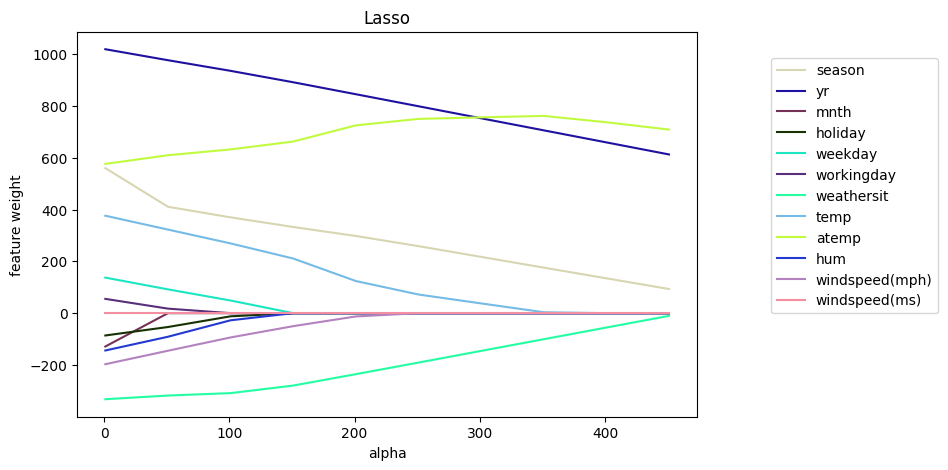

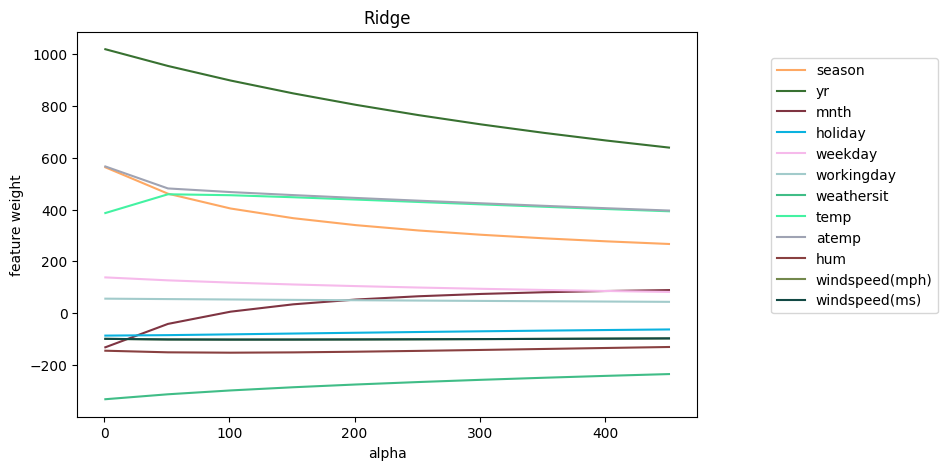

In [32]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge чи Lasso) агресивніше зменшує ваги за одного й того самого alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ній менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?



1.   Lasso
2.   Високе значення alpha призводить до обнулення ваг.
3.   Це властиво для Lasso, однак у Ridge ваги залишаються досить малими, на відміну від повного вимкнення в Lasso.
4.   L1-регуляризація (Lasso) досягає занулення ваг завдяки великому alpha.








## Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна обирати `alpha` за значенням MSE на навчальній вибірці, бо тоді ми не зможемо оцінити, як модель робитиме передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну і тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбивок вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частини, і щоразу брати одну з них як тестову, а з решти блоків складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ зберігатиметься вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [33]:
def create_plot(data, title, xlabel, ylabel, figsize=None, min=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = list(map(lambda e: e[0], data))
    # y = list(map(lambda e: e[1], data))
    x = data[0]
    y = data[1]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if min is not None:
      plt.text(min[0], min[1], f"min: {int(min[0])}x{int(min[1])}", ha="center")
    else:
      m_id = np.argmin(y)
      m_y = np.min(y)
      m_x = x[m_id]
      plt.text(m_x, m_y, f"min: {int(m_x)}x{int(m_y)}", ha="center")

    plt.grid()
    plt.show()

regressor.coef_.shape=(12,)
regressor.alphas.shape=(20,)
regressor.mse_path_.shape=(20, 3)
regressor.alphas_=array([96, 91, 86, 81, 76, 71, 66, 61, 56, 51, 46, 41, 36, 31, 26, 21, 16,
       11,  6,  1])


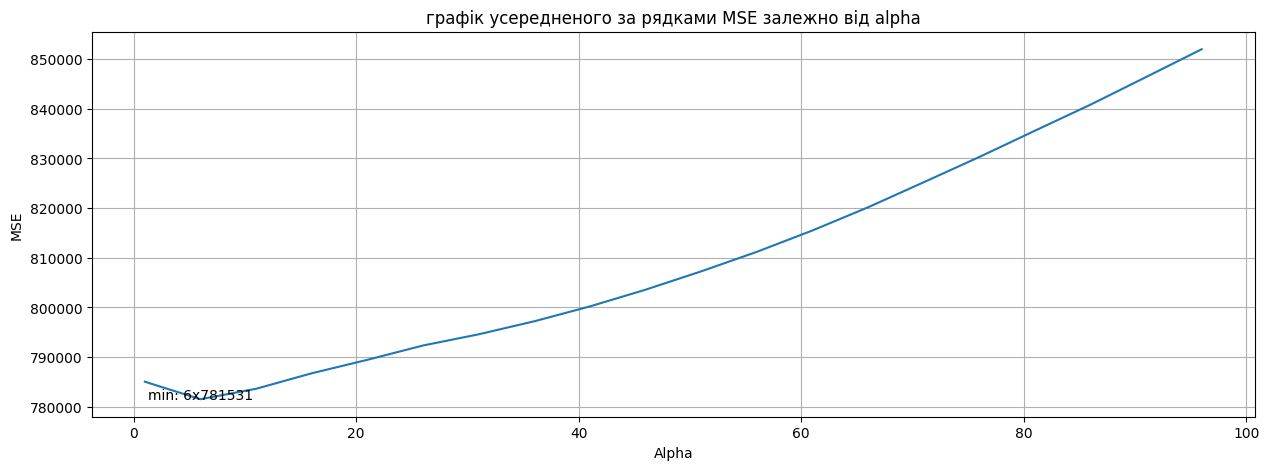

In [34]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(random_state=SEED, alphas=alphas, cv=3)
regressor.fit(X, y)
print(f"{regressor.coef_.shape=}")
print(f"{regressor.alphas.shape=}")
print(f"{regressor.mse_path_.shape=}")
print(f"{regressor.alphas_=}")

mse_values = np.mean(regressor.mse_path_, axis=1)
# print(f"{mse_values=}")

data = np.vstack((regressor.alphas_, mse_values))
# print(f"{data=}")
create_plot(data,"графік усередненого за рядками MSE залежно від alpha","Alpha","MSE")


Отже, ми вибрали деякий параметр регуляризації. Давайте подивимося, які б ми обирали alpha, якби ділили вибірку тільки один раз на навчальну і тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

## Завдання 9



Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [35]:
print("Alphas with minimum MSE:")
print(f"{regressor.mse_path_.shape=}")


min_values = np.min(regressor.mse_path_, axis=0)
print(f"{min_values=}")
min_idx = np.argmin(regressor.mse_path_, axis=0)
print(f"{min_idx=}")
alphas = []
for i, idx in enumerate(min_idx):
  mse = min_values[i]
  alpha = regressor.alphas_[idx]
  alphas.append(alpha)
  print(f"{idx}: Alpha = {alpha}, MSE = {mse}")



# Alpha = 41, MSE = 843336.181499
# Alpha = 6, MSE = 772598.495628
# Alpha = 1, MSE = 745668.605961

Alphas with minimum MSE:
regressor.mse_path_.shape=(20, 3)
min_values=array([733725.76040522, 799433.16736917, 796979.89551936])
min_idx=array([18, 19,  9])
18: Alpha = 6, MSE = 733725.7604052249
19: Alpha = 1, MSE = 799433.1673691692
9: Alpha = 51, MSE = 796979.8955193626


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. Під час вибору `alpha` на крос-валідації ми обираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

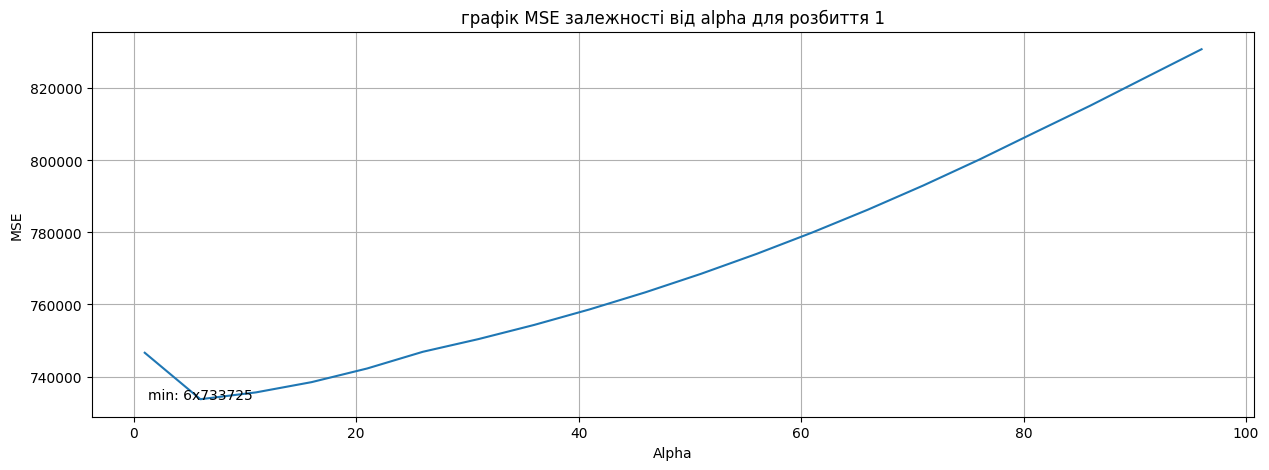

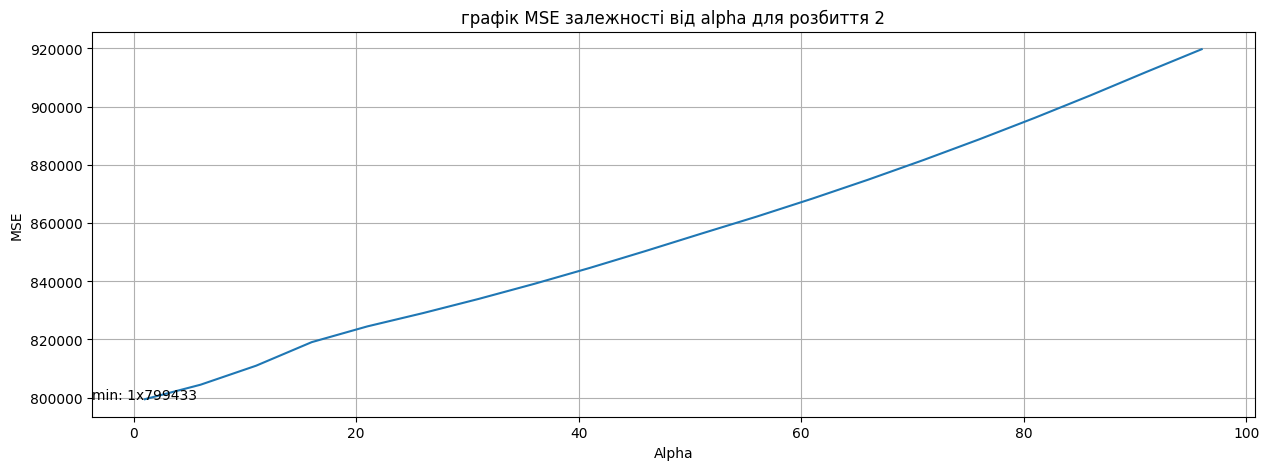

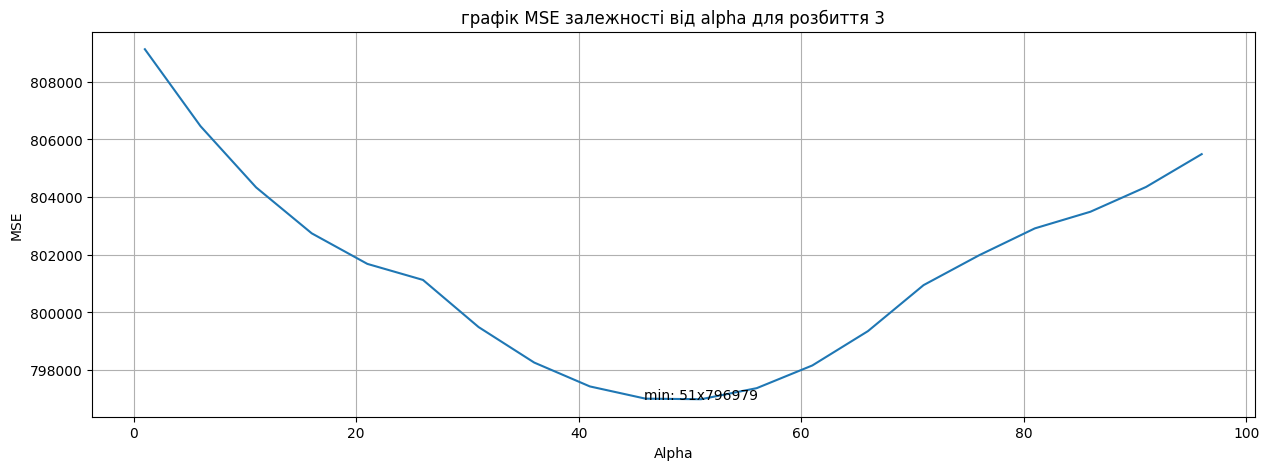

In [36]:
for col in range(regressor.mse_path_.shape[1]):
  data = np.vstack((regressor.alphas_, regressor.mse_path_[:,col]))
  create_plot(data,f"графік MSE залежноcті від alpha для розбиття {col+1}","Alpha","MSE",min=(alphas[col], min_values[col]))


## Завдання 10

Нарешті, як заведено в аналізі даних, давайте проінтерпретуємо результат. Дайте відповідь на такі запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що що більше значення цих ознак, то більше людей захочуть узяти велосипеди?

__Відповідь:__

In [37]:
print(f"{regressor.coef_.shape=}")
for f,w in zip(df.columns, regressor.coef_):
  print(f"{f:15}: {w.round(4)}")

regressor.coef_.shape=(12,)
season         : 532.019
yr             : 1015.0602
mnth           : -100.0395
holiday        : -83.294
weekday        : 132.5045
workingday     : 51.5571
weathersit     : -330.5599
temp           : 370.6799
atemp          : 581.3969
hum            : -140.0074
windspeed(mph) : -191.7714
windspeed(ms)  : -0.0


In [38]:
print(f"{regressor.coef_.shape=}")
for f,w in zip(df.columns, regressor.coef_):
  print(f"{f:15}: {w.round(4)}")

regressor.coef_.shape=(12,)
season         : 532.019
yr             : 1015.0602
mnth           : -100.0395
holiday        : -83.294
weekday        : 132.5045
workingday     : 51.5571
weathersit     : -330.5599
temp           : 370.6799
atemp          : 581.3969
hum            : -140.0074
windspeed(mph) : -191.7714
windspeed(ms)  : -0.0


In [42]:
data_coef = pd.DataFrame(regressor.coef_,index=df.columns[:-1], columns=["Weight"])
data_coef

,Weight
season,5.320190e+02
yr,1.015060e+03
mnth,-1.000395e+02
holiday,-8.329396e+01
weekday,1.325045e+02
workingday,5.155709e+01
weathersit,-3.305599e+02
temp,3.706799e+02
atemp,5.813969e+02
hum,-1.400074e+02


#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем від'ємними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно спадну лінійну залежність? Чи логічно стверджувати, що чим більшою є величина цих ознак, тим менше людей захочуть узяти велосипеди?

__Відповідь:__

In [43]:
data_coef[data_coef < 0].dropna().abs().sort_values(by=['Weight'],ascending=False).head(3)

,Weight
weathersit,330.559857
windspeed(mph),191.771408
hum,140.007406


#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< $1e^{-3}$). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правильно, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [44]:
data_coef[data_coef.abs() < 1e-03].dropna()

,Weight
windspeed(ms),-2.685470e-08


## Висновок


Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як добирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться кілька разів навчати модель. Такий процес займає багато часу, особливо якщо потрібно навчатися на великих обсягах даних.